<a href="https://colab.research.google.com/github/papertuc2000/CL-Drive/blob/dev/CL_Drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1. Connect to Google Drive ---
print("Connecting to Google Drive...")
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [ ]:
# ============================================================
# CL-Drive Multi-Modal Data Generator
# ------------------------------------------------------------
# This generator:
#   • Automatically scans dataset structure
#   • Synchronizes modalities per (participant, level)
#   • Ensures label alignment
#   • Performs sliding-window segmentation
#   • Resamples all signals to a unified sampling rate
#   • Supports classification or regression
#   • Uses file-level caching for speed optimization
#   • Returns dictionary input compatible with fusion models
# ============================================================

import os
from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from scipy.signal import resample


class CLDriveMultiModalGenerator(Sequence):
    """
    Keras-compatible multi-modal generator for CL-Drive dataset.

    Each batch contains:
        X = {
            'ecg_input':  (B, T, C1),
            'eeg_input':  (B, T, C2),
            'eda_input':  (B, T, C3),
            'gaze_input': (B, T, C4)
        }
        y = (B, n_classes) or (B, 1)

    Where:
        B = batch size
        T = window_sec * target_fs (unified temporal length)
        Cx = channel dimension of each modality
    """

    def __init__(
        self,
        dataset_path,
        modalities=('ECG', 'EEG', 'EDA', 'Gaze'),
        batch_size=8,
        window_sec=10,
        target_fs=128,
        shuffle=True,
        task='classification',   # 'classification' or 'regression'
        n_classes=3,
        require_all_modalities=True,
        use_cache=True
    ):

        # ----------------------------
        # Basic configuration
        # ----------------------------
        self.dataset_path = dataset_path
        self.modalities = modalities
        self.batch_size = batch_size
        self.window_sec = window_sec
        self.target_fs = target_fs
        self.shuffle = shuffle
        self.task = task
        self.n_classes = n_classes
        self.require_all_modalities = require_all_modalities
        self.use_cache = use_cache

        # ----------------------------
        # Original sampling rates
        # These are used to compute window boundaries
        # before resampling to target_fs
        # ----------------------------
        self.fs_dict = {
            'ECG': 512,
            'EEG': 256,
            'EDA': 128,
            'Gaze': 50
        }

        # ----------------------------
        # File-level cache:
        # Stores loaded CSV files in memory to
        # avoid repeated disk reads during training
        # ----------------------------
        self.cache = {}

        # --------------------------------------------------
        # Step 1: Build synchronized dataset index
        # --------------------------------------------------
        self.samples = self._build_index()

        # --------------------------------------------------
        # Step 2: Create window index mapping
        # (sample_idx, segment_idx)
        # --------------------------------------------------
        self.indices = self._create_windows()

        self.on_epoch_end()

    # =====================================================
    # Dataset Synchronization
    # =====================================================
    def _build_index(self):
        """
        Scans dataset directory recursively and builds
        synchronized multi-modal index.

        Synchronization logic:
            key = (participant_id, level)

        Only samples satisfying:
            - label file exists
            - required modalities exist
        are included.
        """

        # Collect all CSV files recursively
        all_files = glob(os.path.join(self.dataset_path, "**", "*.csv"), recursive=True)

        synced_data = defaultdict(dict)
        label_files = {}

        for file_path in all_files:

            # Ignore baseline recordings
            if 'baseline' in file_path.lower():
                continue

            parts = file_path.split(os.sep)
            filename = parts[-1]

            # --------------------------
            # Detect label files
            # One label file per participant
            # --------------------------
            if f"{os.sep}Labels{os.sep}" in file_path:
                p_id = parts[-2]
                label_files[p_id] = file_path
                continue

            # --------------------------
            # Detect modality files
            # --------------------------
            for m in self.modalities:
                if f"{os.sep}{m}{os.sep}" in file_path:

                    p_id = parts[-2]

                    # Extract difficulty level from filename
                    if '_level_' in filename:
                        level = filename.split('_level_')[-1].replace('.csv', '')
                        key = (p_id, level)
                        synced_data[key][m] = file_path

                    break

        # --------------------------
        # Final filtering
        # --------------------------
        final_samples = []

        for (p_id, level), files in synced_data.items():

            # Must have labels
            if p_id not in label_files:
                continue

            # Strict multi-modal requirement
            if self.require_all_modalities:
                if not all(m in files for m in self.modalities):
                    continue
            else:
                # Minimal requirement: ECG present
                if 'ECG' not in files:
                    continue

            final_samples.append({
                'p_id': p_id,
                'level': int(level),
                'paths': files,
                'label_path': label_files[p_id]
            })

        print(f"Total synchronized samples: {len(final_samples)}")

        return final_samples

    # =====================================================
    # Window Construction
    # =====================================================
    def _create_windows(self):
        """
        Each subjective label corresponds to one
        10-second segment.

        This method creates index pairs:
            (sample_idx, segment_idx)
        """

        window_indices = []

        for sample_idx, sample in enumerate(self.samples):

            # Load label file to determine number of segments
            label_df = self._load_csv(sample['label_path'])
            n_segments = len(label_df)

            for seg_idx in range(n_segments):
                window_indices.append((sample_idx, seg_idx))

        return window_indices

    # =====================================================
    # CSV Loader with Optional Caching
    # =====================================================
    def _load_csv(self, path):
        """
        Loads CSV file with optional in-memory caching.
        """

        if self.use_cache:
            if path not in self.cache:
                self.cache[path] = pd.read_csv(path)
            return self.cache[path]
        else:
            return pd.read_csv(path)

    # =====================================================
    # Required by Keras Sequence
    # =====================================================
    def __len__(self):
        """
        Returns number of batches per epoch.
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        """
        Shuffle window indices at epoch end
        to prevent ordering bias.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

    # =====================================================
    # Resampling
    # =====================================================
    def _resample_signal(self, signal, orig_fs):
        """
        Resamples signal to unified target_fs.

        Ensures that all modalities share
        identical temporal length:
            window_sec * target_fs
        """

        target_length = int(self.window_sec * self.target_fs)

        if len(signal) == 0:
            return np.zeros((target_length, signal.shape[1]))

        return resample(signal, target_length)

    # =====================================================
    # Segment Extraction
    # =====================================================
    def _load_segment(self, path, modality, seg_idx):
        """
        Extracts a fixed-length time window corresponding
        to the seg_idx-th subjective label.
        """

        df = self._load_csv(path)
        signal = df.values

        orig_fs = self.fs_dict[modality]

        # Compute temporal window boundaries
        start = int(seg_idx * self.window_sec * orig_fs)
        end = int((seg_idx + 1) * self.window_sec * orig_fs)

        segment = signal[start:end]

        # Resample to target frequency
        segment = self._resample_signal(segment, orig_fs)

        return segment.astype(np.float32)

    # =====================================================
    # Label Processing
    # =====================================================
    def _process_label(self, label_value):
        """
        Converts raw subjective score into:
            - one-hot class vector (classification)
            - scalar value (regression)
        """

        if self.task == 'classification':
            return tf.keras.utils.to_categorical(label_value, self.n_classes)
        else:
            return np.array([label_value], dtype=np.float32)

    # =====================================================
    # Batch Construction
    # =====================================================
    def __getitem__(self, index):
        """
        Generates one batch of multi-modal data.
        """

        batch_indices = self.indices[
            index * self.batch_size:(index + 1) * self.batch_size
        ]

        # Initialize per-modality containers
        X_batches = {f"{m.lower()}_input": [] for m in self.modalities}
        y_batch = []

        for sample_idx, seg_idx in batch_indices:

            sample = self.samples[sample_idx]

            # --------------------------
            # Load each modality window
            # --------------------------
            for m in self.modalities:
                segment = self._load_segment(
                    sample['paths'][m],
                    m,
                    seg_idx
                )
                X_batches[f"{m.lower()}_input"].append(segment)

            # --------------------------
            # Load corresponding label
            # --------------------------
            label_df = self._load_csv(sample['label_path'])
            label_value = label_df.iloc[seg_idx].values[0]
            label = self._process_label(label_value)

            y_batch.append(label)

        # Convert lists to numpy arrays
        X = {
            k: np.array(v, dtype=np.float32)
            for k, v in X_batches.items()
        }

        y = np.array(y_batch)

        return X, y

Part 1: Imports

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt



Part 2: Drive Mounting

In [ ]:
# --- 2. Set the Base Path ---
# Update this path if your CL-Drive folder is located elsewhere in your Drive
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/CL-Drive'

# Check if the path exists to prevent errors later
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"Path {BASE_PATH} not found. Please ensure the 'CL-Drive' folder exists in your Google Drive root.")

print(f"Data successfully located at: {BASE_PATH}")

# --- 3. Global Configuration ---
MODALITIES = ['eeg', 'ecg', 'eda', 'gaze']
NUM_PARTICIPANTS = 21
NUM_LEVELS = 9

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data successfully located at: /content/drive/MyDrive/Colab Notebooks/CL-Drive


Part 3: Data Loading


In [ ]:
def clean_csv_data(file_path):
    """
    Reads a CSV file, handles missing values (empty strings or commas),
    and returns a numpy array of numeric data along with column names.
    """
    try:
        # Read CSV assuming the first row contains headers
        df = pd.read_csv(file_path, header=0)

        # Replace empty strings or whitespace-only cells with NaN
        df = df.replace(r'^\s*$', np.nan, regex=True)

        # Fill missing values using Forward Fill (propagate last valid observation forward)
        # Fill any remaining leading NaNs with 0
        df = df.fillna(method='ffill').fillna(0)

        # Select only numeric columns and convert to float32 for TensorFlow compatibility
        data = df.select_dtypes(include=[np.number]).values.astype(np.float32)
        columns = df.columns.tolist()
        return data, columns
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None, None

Part 4: Cleaning Functions


In [ ]:
def get_baseline_mean(participant_id, level, modality):
    """
    Calculates the mean value of the baseline data for a specific participant,
    level, and modality. This is used for normalization later.
    """
    # Map modality keys to folder names
    folder_map = {'eeg': 'EEG', 'ecg': 'ECG', 'eda': 'EDA', 'gaze': 'Gaze'}
    p_folder = f"participant_ID_{participant_id}"

    # Construct search pattern for baseline files
    pattern = os.path.join(BASE_PATH, folder_map[modality], p_folder, f"*baseline_level_{level}*.csv")
    files = glob.glob(pattern)

    if not files:
        return None

    all_data = []
    for f in files:
        d, _ = clean_csv_data(f)
        if d is not None:
            all_data.append(d)

    # FIXED LINE BELOW: Added ': return None'
    if not all_data:
        return None

    # Concatenate all baseline chunks and calculate the mean across time (axis 0)
    combined = np.concatenate(all_data, axis=0)
    return np.mean(combined, axis=0)

Part 5: The Data Generator

In [ ]:
def generator():
    """
    Python generator that yields batches of multimodal data and labels.
    It iterates through participants and levels, loads data, normalizes it,
    and aligns the lengths of all modalities.
    """
    for p_id in range(1, NUM_PARTICIPANTS + 1):
        p_folder = f"participant_ID_{p_id}"

        # Skip if participant folder doesn't exist
        if not os.path.exists(os.path.join(BASE_PATH, "EEG", p_folder)):
            continue

        for level in range(1, NUM_LEVELS + 1):

            sample_data = {}
            valid_sample = True
            min_len = float('inf')

            # --- Load and Normalize Each Modality ---
            for mod in MODALITIES:
                folder_map = {'eeg': 'EEG', 'ecg': 'ECG', 'eda': 'EDA', 'gaze': 'Gaze'}
                pattern = os.path.join(BASE_PATH, folder_map[mod], p_folder, f"*data_level_{level}*.csv")
                files = glob.glob(pattern)

                if not files:
                    valid_sample = False
                    break

                chunks = []
                for f in files:
                    d, _ = clean_csv_data(f)
                    if d is not None:
                        chunks.append(d)

                if not chunks:
                    valid_sample = False
                    break

                # Concatenate chunks if the data was split into multiple files
                data = np.concatenate(chunks, axis=0)

                # Apply Baseline Normalization: Data / Mean_Baseline
                baseline_mean = get_baseline_mean(p_id, level, mod)
                if baseline_mean is not None:
                    # Add small epsilon to avoid division by zero
                    data = data / (baseline_mean + 1e-8)

                sample_data[mod] = data

                # Track the shortest sequence length to align all modalities later
                if data.shape[0] < min_len:
                    min_len = data.shape[0]

            if not valid_sample or min_len == 0:
                continue

            # --- Load Labels ---
            label_pattern = os.path.join(BASE_PATH, "Labels", p_folder, f"*level_{level}*.csv")
            label_files = glob.glob(label_pattern)

            if not label_files:
                continue

            lbl_df = pd.read_csv(label_files[0], header=0)
            lbl_df = lbl_df.replace(r'^\s*$', np.nan, regex=True).fillna(method='ffill').fillna(0)

            # Assume the first numeric column contains the cognitive load score (1-9)
            labels = lbl_df.select_dtypes(include=[np.number]).iloc[:, 0].values.astype(np.int32)

            # --- Align Lengths ---
            # Cut all data and labels to the length of the shortest modality
            final_len = min(min_len, len(labels))

            if final_len < 10: # Skip samples that are too short to be useful
                continue

            out_data = {mod: sample_data[mod][:final_len] for mod in MODALITIES}
            out_labels = labels[:final_len]

            yield out_data, out_labels

Part 6: Creating the TensorFlow Dataset


In [ ]:
# --- Part 4: Creating the TensorFlow Dataset (FIXED) ---

print("Building TensorFlow Dataset... (this may take a moment)")

# Define the output signature for TensorFlow optimization
# Shapes are dynamic (None) because signal lengths vary before batching
output_signature = (
    {
        'eeg': tf.TensorSpec(shape=(None, None), dtype=tf.float32), # (Time, Features)
        'ecg': tf.TensorSpec(shape=(None, None), dtype=tf.float32),
        'eda': tf.TensorSpec(shape=(None, None), dtype=tf.float32),
        'gaze': tf.TensorSpec(shape=(None, None), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

# Create the dataset from the generator
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# Apply transformations: Shuffle, Batch (with padding), and Prefetch
BATCH_SIZE = 16

# FIX: Corrected padded_shapes structure.
# We use a tuple (None, None) for dynamic time and feature dimensions.
# We do NOT wrap None in a list like [None].
final_dataset = dataset.shuffle(buffer_size=100).padded_batch(
    BATCH_SIZE,
    padded_shapes=(
        {
            'eeg': (None, None),
            'ecg': (None, None),
            'eda': (None, None),
            'gaze': (None, None)
        },
        (None,) # Labels shape
    ),
    # Optional: Define padding values (0.0 for features, -1 for labels if needed, but default 0 works for int32 usually)
    padding_values=(
        {
            'eeg': 0.0, 'ecg': 0.0, 'eda': 0.0, 'gaze': 0.0
        },
        0
    )
).prefetch(tf.data.AUTOTUNE)

print("Dataset created successfully!")
try:
    count = tf.data.experimental.cardinality(final_dataset).numpy()
    print(f"Estimated number of batches: {count}")
except Exception:
    print("Could not calculate exact batch count immediately (normal for large datasets).")

# Continue to Part 5 (Visualization)...

Building TensorFlow Dataset... (this may take a moment)
Dataset created successfully!
Estimated number of batches: -2


Part 7: Visualization Functions


In [ ]:
def plot_sample_signals(features, labels, sample_idx=0):
    """
    Plots the raw signals for all 4 modalities for a single sample within a batch.
    """
    plt.figure(figsize=(15, 10))

    modalities_order = ['eeg', 'ecg', 'eda', 'gaze']
    titles = ['EEG (Brain Waves)', 'ECG (Heart Activity)', 'EDA (Skin Conductance)', 'Gaze (Eye Tracking)']

    for i, mod in enumerate(modalities_order):
        data_batch = features[mod].numpy()

        # Determine the actual length of the signal (ignoring padding zeros)
        valid_len = np.where(np.any(data_batch[sample_idx] != 0, axis=1))[0]
        if len(valid_len) == 0: continue
        end_idx = valid_len[-1] + 1

        signal = data_batch[sample_idx, :end_idx, :] # Shape: (Time, Channels)

        plt.subplot(4, 1, i+1)
        time_axis = np.arange(end_idx)

        # Plot channels. If multiple channels exist, offset them slightly for visibility
        if signal.shape[1] > 1:
            for ch in range(min(signal.shape[1], 4)): # Plot max 4 channels
                # Add an offset (ch * 2) so lines don't overlap perfectly
                plt.plot(time_axis, signal[:, ch] + ch * 2, label=f'Ch {ch}', alpha=0.7)
            plt.title(f"{titles[i]} - Normalized (Offset for Visibility)")
            plt.ylabel("Amplitude (offset)")
        else:
            plt.plot(time_axis, signal[:, 0], color='blue')
            plt.title(f"{titles[i]} - Normalized")
            plt.ylabel("Amplitude")

        plt.grid(True, alpha=0.3)
        plt.xticks([]) # Hide x-axis numbers for cleaner look

    plt.xlabel("Time Steps")
    plt.suptitle(f"Sample Signals (Batch Index: {sample_idx})\nLabel Sequence: {labels[sample_idx].numpy()[:15]}...", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_class_distribution(num_samples_to_check=500):
    """
    Scans the dataset and plots a bar chart showing the distribution of
    Cognitive Load classes (Low, Medium, High).
    """
    all_labels = []
    count = 0

    print("Scanning labels for distribution analysis...")
    for features, labels in final_dataset.take(num_samples_to_check // BATCH_SIZE + 1):
        lbls = labels.numpy().flatten()
        # Filter out padding (assuming 0 is not a valid label, as scores are 1-9)
        valid_lbls = lbls[lbls > 0]
        all_labels.extend(valid_lbls)
        count += len(valid_lbls)
        if count >= num_samples_to_check: break

    all_labels = np.array(all_labels)

    # Map raw scores (1-9) to Ternary Classes based on the paper
    ternary_labels = []
    for l in all_labels:
        if 1 <= l <= 3: ternary_labels.append('Low (1-3)')
        elif 4 <= l <= 6: ternary_labels.append('Medium (4-6)')
        elif 7 <= l <= 9: ternary_labels.append('High (7-9)')
        else: ternary_labels.append('Unknown')

    plt.figure(figsize=(8, 6))
    unique, counts = np.unique(ternary_labels, return_counts=True)
    colors = ['green', 'orange', 'red']
    plt.bar(unique, counts, color=colors)

    plt.title(f"Distribution of Cognitive Load Classes (Sampled {len(all_labels)} points)")
    plt.xlabel("Cognitive Load Level")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)

    # Add count numbers on top of bars
    for i, v in enumerate(counts):
        plt.text(i, v + 5, str(v), ha='center')

    plt.tight_layout()
    plt.show()

Part 8: Execution and Testing



--- Generating Visualization Plots ---
Scanning labels for distribution analysis...


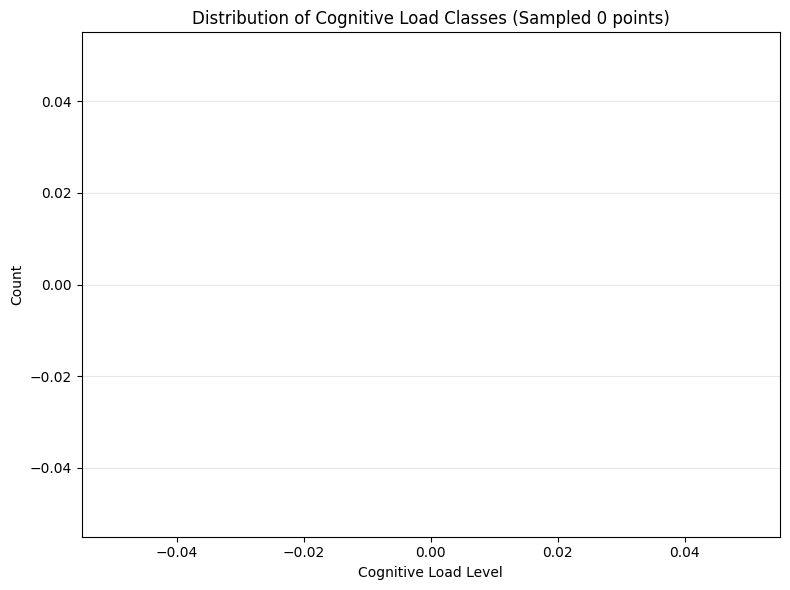


Done! The variable `final_dataset` is now ready to be passed to model.fit().


In [ ]:
# --- Run Visualizations ---
print("\n--- Generating Visualization Plots ---")

# 1. Plot sample signals from the first batch
for feat_batch, lab_batch in final_dataset.take(1):
    plot_sample_signals(feat_batch, lab_batch, sample_idx=0)
    break

# 2. Plot class distribution
plot_class_distribution(num_samples_to_check=500)

print("\nDone! The variable `final_dataset` is now ready to be passed to model.fit().")